In [1]:
from pymongo import MongoClient
import findspark
findspark.init()

In [2]:
import numpy as np 
import pandas as pd
from pyspark.sql import functions as F

In [3]:
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession
    
sc = SparkContext()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

In [4]:
myclient = MongoClient("mongodb://localhost:27017")
mydb = myclient["mydatabase"]
mycol = mydb["log_col"]


In [5]:
n=mycol.count_documents({})
n

5215312

# Spark Session 

In [6]:
spark

# Read data from Mongodb Data Base

In [7]:
df = spark.read.format("mongo").option("uri","mongodb://127.0.0.1/mydatabase.log_col").load()

In [8]:
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- client: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- method: string (nullable = true)
 |-- referer: string (nullable = true)
 |-- request: string (nullable = true)
 |-- size: string (nullable = true)
 |-- status: string (nullable = true)



In [9]:
type(df)

pyspark.sql.dataframe.DataFrame

In [10]:
#df.count()

In [11]:
df.show()

+--------------------+-------------+--------------------+------+--------------------+--------------------+-----+------+
|                 _id|       client|            datetime|method|             referer|             request| size|status|
+--------------------+-------------+--------------------+------+--------------------+--------------------+-----+------+
|[61e6aa21486d33a0...| 54.36.149.41|22/Jan/2019:03:56...|   GET|                   -|/filter/27|13%20%...|30577|   200|
|[61e6aa22486d33a0...|  31.56.96.51|22/Jan/2019:03:56...|   GET|https://www.zanbi...|/image/60844/prod...| 5667|   200|
|[61e6aa23486d33a0...|  31.56.96.51|22/Jan/2019:03:56...|   GET|https://www.zanbi...|/image/61474/prod...| 5379|   200|
|[61e6aa24486d33a0...|40.77.167.129|22/Jan/2019:03:56...|   GET|                   -|/image/14925/prod...| 1696|   200|
|[61e6aa25486d33a0...|  91.99.72.15|22/Jan/2019:03:56...|   GET|                   -|/product/31893/62...|41483|   200|
|[61e6aa26486d33a0...|40.77.167.129|22/J

In [12]:
print(len(df.columns))

8


In [13]:
df.columns

['_id', 'client', 'datetime', 'method', 'referer', 'request', 'size', 'status']

In [14]:
df=df.drop('_id')

# Finding Missing Values

In [15]:
(df
    .filter(df['client']
                .isNull())
    .count())

0

In [16]:
bad_rows_df = df.filter(df['client'].isNull()| 
                             df['datetime'].isNull() | 
                             df['method'].isNull() |
                              df['referer'].isNull() |
                             df['status'].isNull() |
                             df['size'].isNull()|
                             df['request'].isNull())
bad_rows_df.count()

0

* Finding Null Counts

In [17]:
from pyspark.sql.functions import col
from pyspark.sql.functions import sum as spark_sum

def count_null(col_name):
    return spark_sum(col(col_name).isNull().cast('integer')).alias(col_name)

# Build up a list of column expressions, one per column.
exprs = [count_null(col_name) for col_name in df.columns]

# Run the aggregation. The *exprs converts the list of expressions into
# variable function arguments.
df.agg(*exprs).show()

+------+--------+------+-------+-------+----+------+
|client|datetime|method|referer|request|size|status|
+------+--------+------+-------+-------+----+------+
|     0|       0|     0|      0|      0|   0|     0|
+------+--------+------+-------+-------+----+------+



### Data Time

In [18]:
from pyspark.sql.functions import udf

month_map = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

def parse_clf_time(text):
    """ Convert Common Log time format into a Python datetime object
    Args:
        text (str): date and time in Apache time format [dd/mmm/yyyy:hh:mm:ss (+/-)zzzz]
    Returns:
        a string suitable for passing to CAST('timestamp')
    """
    # NOTE: We're ignoring the time zones here, might need to be handled depending on the problem you are solving
    return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
      int(text[7:11]),
      month_map[text[3:6]],
      int(text[0:2]),
      int(text[12:14]),
      int(text[15:17]),
      int(text[18:20])
    )

In [19]:
udf_parse_time = udf(parse_clf_time)

df =df.select('*', udf_parse_time(df['datetime']).cast('timestamp').alias('date')).drop('datetime')
df.show(10, truncate=True)

+-------------+------+--------------------+--------------------+-----+------+-------------------+
|       client|method|             referer|             request| size|status|               date|
+-------------+------+--------------------+--------------------+-----+------+-------------------+
| 54.36.149.41|   GET|                   -|/filter/27|13%20%...|30577|   200|2019-01-22 03:56:14|
|  31.56.96.51|   GET|https://www.zanbi...|/image/60844/prod...| 5667|   200|2019-01-22 03:56:16|
|  31.56.96.51|   GET|https://www.zanbi...|/image/61474/prod...| 5379|   200|2019-01-22 03:56:16|
|40.77.167.129|   GET|                   -|/image/14925/prod...| 1696|   200|2019-01-22 03:56:17|
|  91.99.72.15|   GET|                   -|/product/31893/62...|41483|   200|2019-01-22 03:56:17|
|40.77.167.129|   GET|                   -|/image/23488/prod...| 2654|   200|2019-01-22 03:56:17|
|40.77.167.129|   GET|                   -|/image/45437/prod...| 3688|   200|2019-01-22 03:56:18|
|40.77.167.129|   GE

# Data Analysis on our Web Logs

In [20]:
content_size_summary_df = df.describe(['size'])


In [21]:
content_size_summary_df.show()

+-------+------------------+
|summary|              size|
+-------+------------------+
|  count|           5215312|
|   mean|12282.029658820029|
| stddev| 29196.60366432535|
|    min|                 0|
|    max|              9999|
+-------+------------------+



In [23]:
status_freq_df = (df
                     .groupBy('status')
                     .count()
                     .sort('status')
                     .cache())

In [24]:
status_freq_pd_df = (status_freq_df
                         .toPandas()
                         .sort_values(by=['count'],
                                      ascending=False))
status_freq_pd_df

,status,count
0,200,4808337
4,304,178135
3,302,107501
8,404,52843
2,301,38407
11,499,25903
7,403,2401
12,500,1040
5,400,280
13,502,278


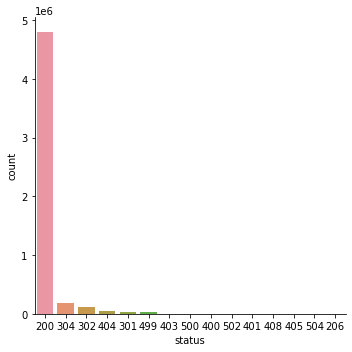

In [25]:
#import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

sns.catplot(x='status', y='count', data=status_freq_pd_df, 
            kind='bar', order=status_freq_pd_df['status'])

In [26]:
log_freq_df = status_freq_df.withColumn('log(count)', F.log(status_freq_df['count']))
log_freq_df.toPandas()

,status,count,log(count)
0,200,4808337,15.385862
1,206,2,0.693147
2,301,38407,10.555995
3,302,107501,11.585255
4,304,178135,12.090297
5,400,280,5.634790
6,401,118,4.770685
7,403,2401,7.783641
8,404,52843,10.875081
9,405,5,1.609438


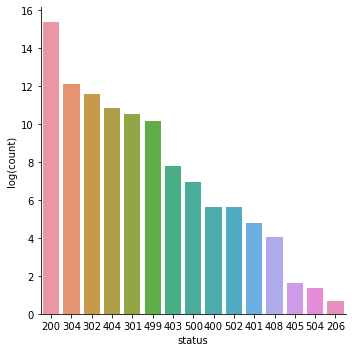

In [27]:
log_freq_pd_df = (log_freq_df
                    .toPandas()
                    .sort_values(by=['log(count)'],
                                 ascending=False))
sns.catplot(x='status', y='log(count)', data=log_freq_pd_df, 
            kind='bar', order=status_freq_pd_df['status'])

# Analyzing Frequent Hosts (Clients)

In [28]:
host_sum_df =(df
               .groupBy('client')
               .count()
               .sort('count', ascending=False).limit(10))

host_sum_df.show()

+---------------+------+
|         client| count|
+---------------+------+
|  66.249.66.194|174153|
|   66.249.66.91|155412|
|151.239.241.163| 62244|
|   66.249.66.92| 49041|
|    91.99.30.32| 45500|
|   5.78.190.233| 26137|
|195.181.168.181| 24773|
|  104.222.32.94| 17553|
|    91.99.72.15| 17063|
|   66.249.66.93| 13692|
+---------------+------+



In [29]:
is200_df = (df.filter(df['status'] == 200))

endpoints_freq_df = (is200_df
                               .groupBy('client')
                               .count()
                               .sort('count', ascending=False)
                               .limit(10)
                          )

In [30]:
endpoints_freq_df.show(truncate=False)

+---------------+------+
|client         |count |
+---------------+------+
|66.249.66.194  |148683|
|66.249.66.91   |57611 |
|151.239.241.163|53162 |
|91.99.30.32    |38338 |
|195.181.168.181|24287 |
|5.78.190.233   |21482 |
|91.99.72.15    |16991 |
|104.222.32.94  |16918 |
|66.249.66.92   |14624 |
|195.181.168.164|11763 |
+---------------+------+



# Display the Top 20 Frequent EndPoints

In [32]:
paths_df = (df
            .groupBy('request')
            .count()
            .sort('count', ascending=False).limit(20))
paths_df.show()

,request,count
0,/settings/logo,168425
1,/static/css/font/wyekan/font.woff,145778
2,/static/images/guarantees/bestPrice.png,62150
3,/static/images/guarantees/goodShopping.png,59985
4,/site/alexaGooleAnalitic,59428
5,/static/images/guarantees/fastDelivery.png,54773
6,/static/images/guarantees/warranty.png,54441
7,/static/images/guarantees/support.png,44908
8,/favicon.ico,44841
9,/static/images/amp/telegram.png,43003


# Top Ten Error Endpoints

In [33]:
not200_df = (df
               .filter(df['status'] != 200))

error_endpoints_freq_df = (not200_df
                               .groupBy('request')
                               .count()
                               .sort('count', ascending=False)
                               .limit(10)
                          )

In [34]:
error_endpoints_freq_df.show()

+--------------------+-----+
|             request|count|
+--------------------+-----+
|/static/css/font/...|90195|
|/static/images/gu...|18362|
|/static/images/gu...|16010|
|/static/images/gu...|11721|
|/static/images/gu...|10820|
|                   /| 9719|
|/plugins/ckeditor...| 9604|
|/apple-touch-icon...| 8594|
|/images/raty/star...| 8468|
|/apple-touch-icon...| 8031|
+--------------------+-----+



# Number of Unique Daily Hosts

In [35]:
unique_host_count = (df
                     .select('client')
                     .distinct()
                     .count())
unique_host_count

124883

# Number of Unique Daily Hosts

In [36]:
host_day_df = df.select(df.client, 
                             F.dayofmonth('date').alias('day'))
host_day_df.show(5, truncate=False)

+-------------+---+
|client       |day|
+-------------+---+
|54.36.149.41 |22 |
|31.56.96.51  |22 |
|31.56.96.51  |22 |
|40.77.167.129|22 |
|91.99.72.15  |22 |
+-------------+---+
only showing top 5 rows



In [37]:
#counting distinct days
(host_day_df.select('day')
.distinct()
.count())

3

* daily_unique_hosts_df


In [38]:
host_day_distinct_df = (host_day_df
                          .dropDuplicates())
host_day_distinct_df.show(5, truncate=False)

+-------------+---+
|client       |day|
+-------------+---+
|46.51.119.113|22 |
|54.36.148.244|22 |
|54.36.149.27 |22 |
|5.121.216.12 |22 |
|54.36.148.178|22 |
+-------------+---+
only showing top 5 rows



In [40]:
def_mr = pd.get_option('max_rows')
pd.set_option('max_rows', 10)

daily_hosts_df = (host_day_distinct_df
                     .groupBy('day')
                     .count()
                     .sort("day"))

daily_hosts_df = daily_hosts_df.toPandas()
daily_hosts_df

,day,count
0,22,53196
1,23,58900
2,24,20917


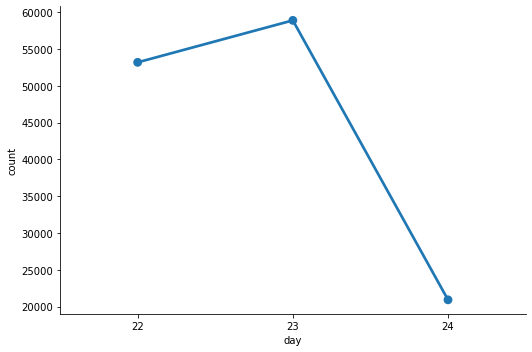

In [41]:
c = sns.catplot(x='day', y='count', 
                data=daily_hosts_df, 
                kind='point', height=5, 
                aspect=1.5)

In [42]:
#counting distinct hours
host_hour_df = df.select(df.client, 
                             F.hour('date').alias('hour'))
host_hour_df.show(5, truncate=False)

+-------------+----+
|client       |hour|
+-------------+----+
|54.36.149.41 |3   |
|31.56.96.51  |3   |
|31.56.96.51  |3   |
|40.77.167.129|3   |
|91.99.72.15  |3   |
+-------------+----+
only showing top 5 rows



In [43]:
#counting distinct days
(host_hour_df.select('hour')
.distinct()
.count())

24

In [44]:
#def_mr = pd.get_option('max_rows')
#pd.set_option('max_rows', 10)

daily_hosts_df = (host_hour_df
                     .groupBy('hour')
                     .count()
                     .sort("hour"))

daily_hosts_df = daily_hosts_df.toPandas()
daily_hosts_df

,hour,count
0,0,154304
1,1,109961
2,2,59500
3,3,38613
4,4,45591
...,...,...
19,19,219287
20,20,216491
21,21,211233
22,22,228583


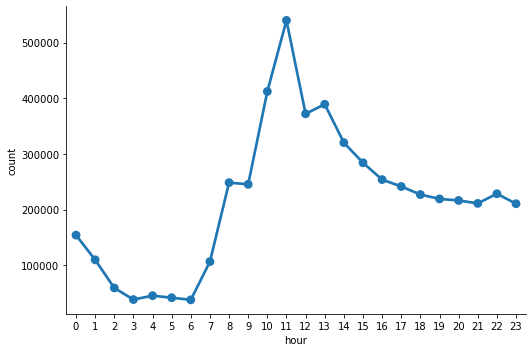

In [45]:
c = sns.catplot(x='hour', y='count', 
                data=daily_hosts_df, 
                kind='point', height=5, 
                aspect=1.5)

# Average Number of Daily Requests per Host

In [46]:
daily_hosts_df = (host_day_distinct_df
                     .groupBy('day')
                     .count()
                     .select(col("day"), 
                                      col("count").alias("total_hosts")))

total_daily_reqests_df = (df
                              .select(F.dayofmonth("date")
                                          .alias("day"))
                              .groupBy("day")
                              .count()
                              .select(col("day"), 
                                      col("count").alias("total_reqs")))

avg_daily_reqests_per_host_df = total_daily_reqests_df.join(daily_hosts_df, 'day')
avg_daily_reqests_per_host_df = (avg_daily_reqests_per_host_df
                                    .withColumn('avg_reqs', col('total_reqs') / col('total_hosts'))
                                    .sort("day"))
avg_daily_reqests_per_host_df = avg_daily_reqests_per_host_df.toPandas()
avg_daily_reqests_per_host_df


,day,total_reqs,total_hosts,avg_reqs
0,22,2160893,53196,40.621344
1,23,2328468,58900,39.532564
2,24,725951,20917,34.706268


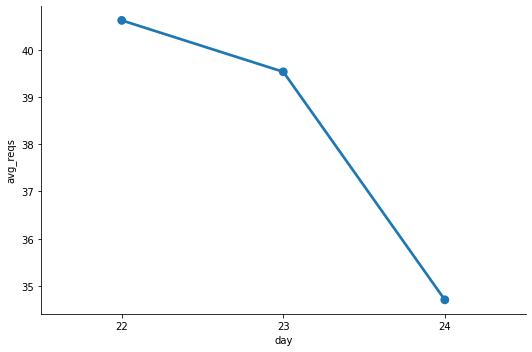

In [47]:
c = sns.catplot(x='day', y='avg_reqs', 
                data=avg_daily_reqests_per_host_df, 
                kind='point', height=5, aspect=1.5)

# Counting 404 Response Codes

In [48]:
not_found_df = df.filter(df["status"] == 404).cache()
print(('Total 404 responses: {}').format(not_found_df.count()))

Total 404 responses: 52843


> Listing the Top Twenty 404 Response Code Hosts

In [49]:
hosts_404_count_df = (not_found_df
                          .groupBy("client")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

hosts_404_count_df.show(truncate=False)

+---------------+-----+
|client         |count|
+---------------+-----+
|66.249.66.194  |6719 |
|2.191.96.86    |612  |
|5.117.116.238  |431  |
|91.99.30.32    |361  |
|151.239.241.163|330  |
|86.55.249.206  |272  |
|95.82.39.94    |264  |
|31.184.130.52  |258  |
|5.78.190.233   |253  |
|37.32.29.198   |199  |
|86.55.53.198   |183  |
|5.210.207.0    |178  |
|178.131.221.63 |151  |
|31.2.167.54    |128  |
|66.249.66.197  |124  |
|5.117.12.120   |112  |
|178.197.228.166|112  |
|222.147.109.159|111  |
|151.241.215.72 |104  |
|5.218.60.6     |104  |
+---------------+-----+



# Visualizing 404 Errors per Day

In [50]:
errors_by_date_sorted_df = (not_found_df
                                .groupBy(F.dayofmonth('date').alias('day'))
                                .count()
                                .sort("day"))

errors_by_date_sorted_pd_df = errors_by_date_sorted_df.toPandas()
errors_by_date_sorted_pd_df

,day,count
0,22,20955
1,23,23737
2,24,8151


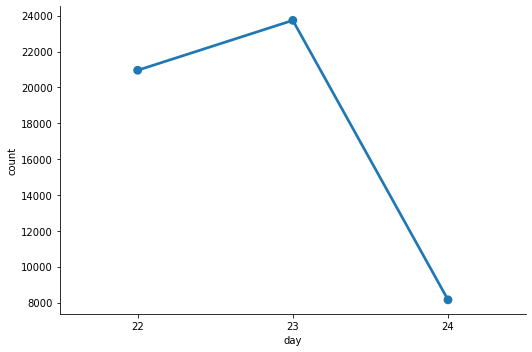

In [51]:
c = sns.catplot(x='day', y='count', 
                data=errors_by_date_sorted_pd_df, 
                kind='point', height=5, aspect=1.5)

# Visualizing Hourly 404 Errors

In [52]:
hourly_avg_errors_sorted_df = (not_found_df
                                   .groupBy(F.hour('date')
                                             .alias('hour'))
                                   .count()
                                   .sort('hour'))
hourly_avg_errors_sorted_pd_df = hourly_avg_errors_sorted_df.toPandas()

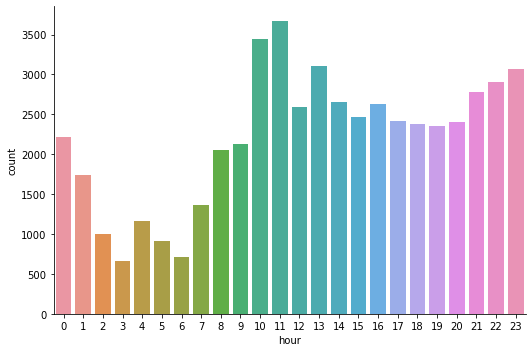

In [53]:
c = sns.catplot(x='hour', y='count', 
                data=hourly_avg_errors_sorted_pd_df, 
                kind='bar', height=5, aspect=1.5)

## clustering 

In [54]:
from pyspark.ml.fpm import FPGrowth
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.types import *
import matplotlib.pyplot as plt

In [55]:
df = df.withColumn("size", df["size"].cast(IntegerType()))

In [56]:
assembler = VectorAssembler(inputCols=["size"],outputCol="features")
cl=assembler.transform(df.select("size"))
cl.select("features").show(truncate=False)

+---------+
|features |
+---------+
|[30577.0]|
|[5667.0] |
|[5379.0] |
|[1696.0] |
|[41483.0]|
|[2654.0] |
|[3688.0] |
|[14776.0]|
|[34277.0]|
|[1695.0] |
|[39677.0]|
|[9831.0] |
|[20406.0]|
|[1796.0] |
|[41725.0]|
|[2739.0] |
|[33617.0]|
|[2788.0] |
|[3481.0] |
|[19451.0]|
+---------+
only showing top 20 rows



In [57]:
kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(cl)

In [58]:
# Make predictions
predictions = model.transform(cl)

In [62]:
type(predictions)

pyspark.sql.dataframe.DataFrame

In [63]:
predictions.groupBy('prediction').count().orderBy('count', ascending=False).show()

+----------+-------+
|prediction|  count|
+----------+-------+
|         0|4952468|
|         2| 255967|
|         1|   6877|
+----------+-------+



In [64]:
evaluator = ClusteringEvaluator()

In [65]:
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.9370535683711652
